### Introduction

In this kernel I use XGBRegressor from XGBoost library to predict future prices of stocks using technical indicator as features. If you are looking for an explanation of indicators (e.g. moving averages, RSI, MACD) used below, please refer to [articles on Investopedia](https://www.investopedia.com/technical-analysis-4689657) or [this notebook of mine](https://www.kaggle.com/mtszkw/analysis-and-technical-indicators-for-trading-etfs) where I introduce and visualize various technical analysis concepts.

In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV


# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)


In [185]:
ETF_NAME = './hist_data/stocks/ERX.txt'

df = pd.read_csv(ETF_NAME, sep=',')

df['Date'] = pd.to_datetime(df['Date'])
df.index = range(len(df))

df.head()

Unnamed: 0       Date        Open        High         Low       Close  \
0           0 2015-08-07  365.399994  374.000000  346.100006  349.600006   
1           1 2015-08-10  353.100006  383.799988  352.700012  383.200012   
2           2 2015-08-11  361.899994  386.600006  358.500000  385.600006   
3           3 2015-08-12  379.899994  409.500000  374.899994  406.600006   
4           4 2015-08-13  397.000000  403.200012  386.399994  388.700012   

    Adj Close    Volume  
0  311.230042  247310.0  
1  341.142395  248230.0  
2  343.278961  230260.0  
3  361.974091  287590.0  
4  346.038727  195750.0

### OHLC Chart

I start with drawing an OHLC (open/high/low/close) chart to get a sense of historical prices. Below OHLC I draw Volume chart which shows number of stocks traded each day. In my previous notebook (linked above) I explain importance of OHLC and Volume charts in technical analysis.

In [186]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

### Decomposition

### Technical indicators

#### Moving Averages

I'm calculating few moving averages to be used as features: $SMA_{5}$, $SMA_{10}$, $SMA_{15}$, $SMA_{30}$ and $EMA_{9}$.

In [187]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

#### Relative Strength Index

I'll add RSI indicator to predict whether a stock is overbought/oversold.

In [188]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi
df['RSI'] = relative_strength_idx(df).fillna(0)
df['RSI_5'] = relative_strength_idx(df, 5).fillna(0)
df['RSI_21'] = relative_strength_idx(df, 21).fillna(0)
df['RSI_55'] = relative_strength_idx(df, 55).fillna(0)
df['RSI_89'] = relative_strength_idx(df, 89).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

#### MACD

In [189]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

EMA_12 = pd.Series(df['Close'].ewm(span=34, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=89, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_slow_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

### Shift label column

Because I want to predict the next day price, after calculating all features for day $D_{i}$, I shift Close price column by -1 rows. After doing that, for day $D_{i}$ we have features from the same timestamp e.g. $RSI_{i}$, but the price $C_{i+1}$ from upcoming day.

In [190]:
df['close_close_change'] = df['Close'].pct_change()
df['close_close_change'] = df['close_close_change'].shift(-2)
df['target'] = np.where(df['close_close_change'] > 0.0, 1, 0)
df.drop(['close_close_change'], axis=1, inplace=True)
print(df['target'].head())
df[-3:]

0    1
1    1
2    0
3    0
4    1
Name: target, dtype: int32


Unnamed: 0       Date       Open       High        Low      Close  \
2424        2424 2025-03-26  66.089996  67.110001  65.389999  65.650002   
2425        2425 2025-03-27  65.500000  65.760002  63.950001  64.480003   
2426        2426 2025-03-28  64.220001  64.699997  63.139999  63.770000   

      Adj Close    Volume      EMA_9      SMA_5  ...     SMA_30        RSI  \
2424  65.650002  285300.0  61.242364  64.278000  ...  60.381333  83.928558   
2425  64.480003  175900.0  61.683128  64.638001  ...  60.485333  75.514260   
2426  63.770000  131700.0  61.962816  64.668001  ...  60.655667  70.627487   

          RSI_5     RSI_21     RSI_55     RSI_89      MACD  MACD_signal  \
2424  75.423713  60.502281  55.495136  48.936171 -0.091925     0.500968   
2425  51.773059  59.595203  55.014898  48.134331  0.031021     0.681896   
2426  53.808361  57.190757  53.612820  47.969108  0.119534     0.819762   

      MACD_slow_signal  target  
2424         -0.600631       0  
2425         -0.474301       0  
2426         -0.355534       0  

[3 rows x 22 columns]

### Drop invalid samples

Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated $SMA_{10}$ for the first 10 days. Moreover, after shifting Close price column, last row price is equal to 0 which is not true. Removing these samples should help.

In [191]:
df = df.iloc[89:] # Because of moving averages and MACD line
df = df[:-2]      # Because of shifting close price

df.index = range(len(df))

Here I split stock data frame into three subsets: training ($70\%$), validation ($15\%$) and test ($15\%$) sets. I calculated split indices and create three separate frames (train_df, valid_df, test_df). All three frames have been ploted in the chart below.

In [192]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.target, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.target, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.target,  name='Test'))
fig.show()

### Drop unnecessary columns

In [193]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']

train_df = train_df.drop(drop_cols, axis=1)
valid_df = valid_df.drop(drop_cols, axis=1)
test_df  = test_df.drop(drop_cols, axis=1)

### Split into features and labels

In [194]:
y_train = train_df['target'].copy()
X_train = train_df.drop(['target'], axis=1)

y_valid = valid_df['target'].copy()
X_valid = valid_df.drop(['target'], axis=1)

y_test  = test_df['target'].copy()
X_test  = test_df.drop(['target'], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1636 non-null   int64  
 1   Close             1636 non-null   float64
 2   Adj Close         1636 non-null   float64
 3   EMA_9             1636 non-null   float64
 4   SMA_5             1636 non-null   float64
 5   SMA_10            1636 non-null   float64
 6   SMA_15            1636 non-null   float64
 7   SMA_30            1636 non-null   float64
 8   RSI               1636 non-null   float64
 9   RSI_5             1636 non-null   float64
 10  RSI_21            1636 non-null   float64
 11  RSI_55            1636 non-null   float64
 12  RSI_89            1636 non-null   float64
 13  MACD              1636 non-null   float64
 14  MACD_signal       1636 non-null   float64
 15  MACD_slow_signal  1636 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 204

### Fine-tune XGBoostRegressor

In [195]:
%%time
parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
eval_set = [(X_train, y_train), (X_valid, y_valid)]
'''
model = xgb.XGBClassifier(eval_set=eval_set, objective='binary:logistic', verbose=False, scale_pos_weight=ratio)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')
best_params = clf.best_params_
'''

CPU times: total: 0 ns
Wall time: 1 ms


"\nmodel = xgb.XGBClassifier(eval_set=eval_set, objective='binary:logistic', verbose=False, scale_pos_weight=ratio)\nclf = GridSearchCV(model, parameters)\n\nclf.fit(X_train, y_train)\n\nprint(f'Best params: {clf.best_params_}')\nprint(f'Best validation score = {clf.best_score_}')\nbest_params = clf.best_params_\n"

In [203]:
%%time

best_params = {'gamma': 0.02, 'learning_rate': 0.01, 'max_depth': 21, 'n_estimators': 42, 'random_state': 42}
# Set scale_pos_weight in the model
model = xgb.XGBClassifier(**best_params, objective='binary:logistic', scale_pos_weight=ratio)
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)


CPU times: total: 5.45 s
Wall time: 609 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.02, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=21, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=42, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

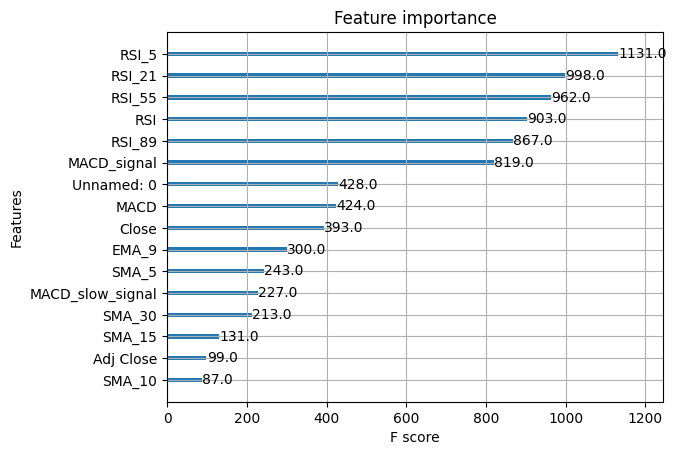

In [204]:
plot_importance(model);

store model

In [205]:
model.save_model("model.bin")

c:\Users\nick5\miniconda3\envs\tree-env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:02:26] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.



### Calculate and visualize predictions

In [206]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [0 0 0 0 0]
y_pred = [1 1 1 1 1]


In [207]:
# Filter data for the test period
test_data = df.loc[test_split_idx+1:].copy()
test_data['Predictions'] = y_pred  # Store predictions in a new column

# Create a scatter plot for the actual prices (test data only)
fig = go.Figure(data=[go.Scatter(x=test_data.Date, y=test_data.Close, name='Truth', marker_color='LightSkyBlue')])

# Add markers for buy and sell signals (test data only)
buy_indices = test_data[test_data['Predictions'] == 1].index
sell_indices = test_data[test_data['Predictions'] == 0].index

fig.add_trace(go.Scatter(x=test_data.Date.loc[buy_indices],
                         y=test_data.Close.loc[buy_indices],
                         mode='markers',
                         marker=dict(symbol='triangle-up', size=10, color='green'),
                         name='Buy'))

fig.add_trace(go.Scatter(x=test_data.Date.loc[sell_indices],
                         y=test_data.Close.loc[sell_indices],
                         mode='markers',
                         marker=dict(symbol='triangle-down', size=10, color='red'),
                         name='Sell'))

fig.show()

In [208]:
# Filter data for the test period
test_data = df.loc[test_split_idx+1:].copy()
test_data['Predictions'] = y_pred  # Store predictions in a new column

# Calculate daily returns
test_data['Returns'] = test_data['Close'].pct_change()

# Shift returns by one day to align with signal execution
test_data['Strategy_Returns'] = test_data['Predictions'].shift(2) * test_data['Returns']

# Calculate cumulative returns
test_data['Cumulative_Returns'] = (1 + test_data['Strategy_Returns']).cumprod()

# Calculate profitability
profitability = test_data['Cumulative_Returns'].iloc[-1] - 1

print(f"Profitability: {profitability:.2%}")

# Plot cumulative returns
fig = go.Figure(data=[go.Scatter(x=test_data.Date, y=test_data.Cumulative_Returns, name='Cumulative Returns')])
fig.show()

Profitability: 0.77%


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Accuracy: 0.5034013605442177
Precision: 0.48404255319148937
Recall: 0.65
F1-score: 0.5548780487804877


In [22]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()